# Exploratory Data Analysis

 - Wind forecast and wind power from __2009/07/01 to 2011/01/01__, the initial train phase
 - Wind forecast and wind power on 36 hours phases between each of the 157 test periods on which you can retrain you models

In [46]:
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

pd.options.mode.chained_assignment = None  # default='warn'

In [47]:
training_data_1 = pd.read_csv("Data/Initial/train.csv")
testing_data_1 = pd.read_csv("Data/Initial/test.csv")

wp_1_forecast = pd.read_csv("Data/Initial/wp1.csv")
# wp_2_forecast = pd.read_csv("Data/Initial/wp2.csv")
# wp_3_forecast = pd.read_csv("Data/Initial/wp3.csv")
# wp_4_forecast = pd.read_csv("Data/Initial/wp4.csv")
# wp_5_forecast = pd.read_csv("Data/Initial/wp5.csv")
# wp_6_forecast = pd.read_csv("Data/Initial/wp6.csv")

In [48]:
wp_1_forecast.head()

,date,hors,u,v,ws,wd
0,2009070100,1,3.14,-3.62,4.79,139.09
1,2009070100,2,2.96,-3.56,4.63,140.26
2,2009070100,3,2.89,-3.46,4.51,140.15
3,2009070100,4,2.87,-3.33,4.40,139.26
4,2009070100,5,2.80,-3.19,4.25,138.73


Pour limiter les données d'entrainement j'utilise l'heure du dernier forecast (*forecast_time*) avant les données test à prédire et non les heures prédites par le forecast (*date*), afin de ne pas utiliser des données dans le future tout en conservant celles du future qui ont été prédites dans le passé... 

Par contre pour les données tests j'ai choisi d'utiliser un créneau plus large que la date de départ, afin d'avoir les 4 forecast de 36h précedants les premières heures de prédiction à fournir. Cela permettra de faire du rolling windows sur ces données et de récupérer les features d'intêret.

In [49]:
# 36hrs before the real start date of the prediction
before_start_36h = '2010-12-30 13:00:00'
start_date = '2011-01-01 01:00:00'
start_forecastdate = '2011-01-01 00:00:00'
without_wp_date = '2010-12-30 12:00:00'
end_date = '2012-06-25 00:00:00'

In [50]:
# datetime(2011,1,1,1,0,0)+timedelta(hours=(36+48)*155)-timedelta(hours=36)

# Functions

In [51]:
def integer2date(s):
    s = str(s)
    return  datetime(year=int(s[0:4]), month=int(s[4:6]), day=int(s[6:8]), hour=int(s[8:]))

def adding_hours(h):
    return timedelta(hours = h)

def date_conversion(df):
    """ Converts the given time of forecast and distance to the forecast into the forecast date."""
    df['forecast_time'] = df.date.apply(lambda x: integer2date(x))
    df['hours_added'] = df.hors.apply(lambda x: adding_hours(x))
    df['date'] = df['forecast_time'] + df['hours_added']
    df = df.drop(['hours_added', 'hors'], axis = 1)
    return df

In [52]:
def forecast_batch(df):
    """Creates a batch number feature for each 48h predicted."""
    i = 1
    for date in df.date.unique():
        df.loc[df.date == date, 'forecast'] = i
        i += 1
    return df 

def forecast_distance(df):
    """Computes the distance from the time of forecast and the date forecast. 
    The incertitude of the forecast increases with the distance"""
    df.sort_values(by = ['forecast', 'date'], inplace = True)
    for cast in df.forecast.unique():
        nb_forecast = len(df.loc[df.forecast == cast, 'date'])
        i = 0
        for date in df[df.forecast == cast].date.unique():
            df.loc[(df.forecast == cast)&(df.date == date), 'forecast_dist'] = i
            i+=1  
    return df

In [53]:
def hr_func(ts):
    return ts.hour

def month_func(ts):
    return ts.month

def feature_engineering(df):  
    df['cos_hour'] = np.cos(2*np.pi *(df['date']).apply(hr_func)/24)
    df['sin_hour'] = np.sin(2*np.pi *(df['date']).apply(hr_func)/24)
    
    df['cos_month'] = np.cos(2*np.pi *df['date'].apply(month_func)/12)
    df['sin_month'] = np.sin(2*np.pi *df['date'].apply(month_func)/12)
    
#     Ajouter le traitement de u et v
    
    df['cos_wd'] = np.cos(df['wd'])
    df['sin_wd'] = np.sin(df['wd'])
#     df.drop("wd", inplace = True)
#     Not necessary, the ws distribution is a slighly skewed gaussian
#     df['cosws'] = np.cos(df['ws'])
#     df['sinws'] = np.sin(df['ws'])

    df['ws_correction'] = np.sqrt(wp_1_forecast['ws'])
    df['ws3'] = df['ws']**3
    
    return df

In [54]:
def wp_getter(df, target, target_wp_col):
    for date in target.date.unique():
         df.loc[df.date == date, 'wp'] = target.loc[target.date == date, target_wp_col].values[0]
    return df

In [55]:
def rolling_window_48h(df):
    """Makes a rolling window for each batch of 48h forecast. 
    The goal here is to take the 36h prior which have the smallest distance to forecast time. This way, 
    the forecast (u,v,ws...) used is more accurate."""
    df_rolled = pd.DataFrame()   
    nb_48h = int(len(df)/48 + 1)
    for i in range(4, nb_48h): 
            condition = (df.forecast >= i-3) & (df.forecast <= i)
            forecast_48 = df[condition].sort_values(by = ['date', 'forecast_time'], ascending=[True, False])
            forecast_48 = forecast_48.drop_duplicates(subset = 'date')
            forecast_48 = rolling_windows(forecast_48)
            forecast_48 = forecast_48[forecast_48.forecast == i]
            df_rolled = pd.concat([df_rolled, forecast_48], ignore_index=True)
    return df_rolled


def rolling_windows(df):
    # Wind speed
    for i in [1, 2, 3, 4, 5, 6, 7, 8, 12, 24]:
        df['ws_T_' + str(i)] = df['ws'].shift(i)     
    
    for i in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 24]:
        df['ws_T_' + str(i) + '_mean'] = df['ws'].rolling(window = i).mean() 
        
    for i in [2, 3, 4, 5, 6, 12]:
        df['ws_T_' + str(i) + '_std'] = df['ws'].rolling(window = i).std()
        
    for i in [2, 3, 4, 5, 6, 12]:
        df['ws_T_' + str(i) + '_median'] = df['ws'].rolling(window = i).median()
        
    for i in [1, 2, 3, 4, 5, 6, 12, 24]:
        df['ws_T_' + str(i) + '_max'] = df['ws'].rolling(window = i).max()    
        
    for i in [1, 2, 3, 4, 5, 6, 12, 24]:
        df['ws_T_' + str(i) + '_min'] = df['ws'].rolling(window = i).min()         
       
    # u 
    for i in [1, 2, 3, 4, 5, 6, 12, 24]:
        df['x_T_' + str(i)] = df['u'].shift(i)
        
    for i in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
        df['x_T_' + str(i) + '_mean'] = df['u'].rolling(window = i).mean()  
        
    for i in [2, 3, 4, 5, 6]:
        df['x_T_' + str(i) + '_std'] = df['u'].rolling(window = i).std()     
        
    # v
    for i in [1, 2, 3, 4, 5, 6, 12, 24]:
        df['y_T_' + str(i)] = df['v'].shift(i)
        
    for i in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
        df['y_T_' + str(i) + '_mean'] = df['v'].rolling(window = i).mean()  
        
    for i in [2, 3, 4, 5, 6]:
        df['y_T_' + str(i) + '_std'] = df['v'].rolling(window = i).std()        

    return df

In [56]:
def forecast_nb_to_predict(df, target_dates, start_forecastdate):
    """Returns a list of the forecast number to be predicted for the contest."""
    first_nb = df[df.forecast_time >= start_forecastdate].head(1).forecast.values[0]
    nb_forecast = int(len(target_dates)/48)
    cast_predict = [first_nb]
    for i in range(1, nb_forecast):
        cast_predict.append(cast_predict[i-1] + 7)
    return cast_predict

# Date correction

In [57]:
training_data_1['date'] = training_data_1.date.apply(lambda x: integer2date(x))

In [58]:
testing_data_1['date'] = testing_data_1.date.apply(lambda x: integer2date(x))

In [59]:
len(testing_data_1)/48

155.0

# WP1 preprocessing

In [60]:
wp_1_forecast = forecast_batch(wp_1_forecast)
wp_1_forecast = date_conversion(wp_1_forecast)
wp_1_forecast = forecast_distance(wp_1_forecast)
wp_1_forecast = feature_engineering(wp_1_forecast)

In [61]:
wp_1_forecast = wp_getter(wp_1_forecast, training_data_1, 'wp1')

In [ ]:
# wp_1_forecast = rolling_window_48h(wp_1_forecast)

## Cleaning the technical maintenance period

In [ ]:
# wp_to_predict = forecast_nb_to_predict(wp_1_forecast, testing_data_1, start_forecastdate)
# wp_1_forecast_cl = wp_1_forecast[~((wp_1_forecast.wp <=0) & (wp_1_forecast.ws > 3.3)) & (~wp_1_forecast.forecast.isin(wp_to_predict))]

# Separation into training and testing data

For the predicted data, I choose to take a larger sample in order to use the rolling_windows function

In [62]:
wp_1_training = wp_1_forecast[(wp_1_forecast.forecast_time < without_wp_date)]

In [ ]:
# wp_1_testing = wp_1_forecast[(wp_1_forecast.date >= before_start_36h)]

# Visualisation

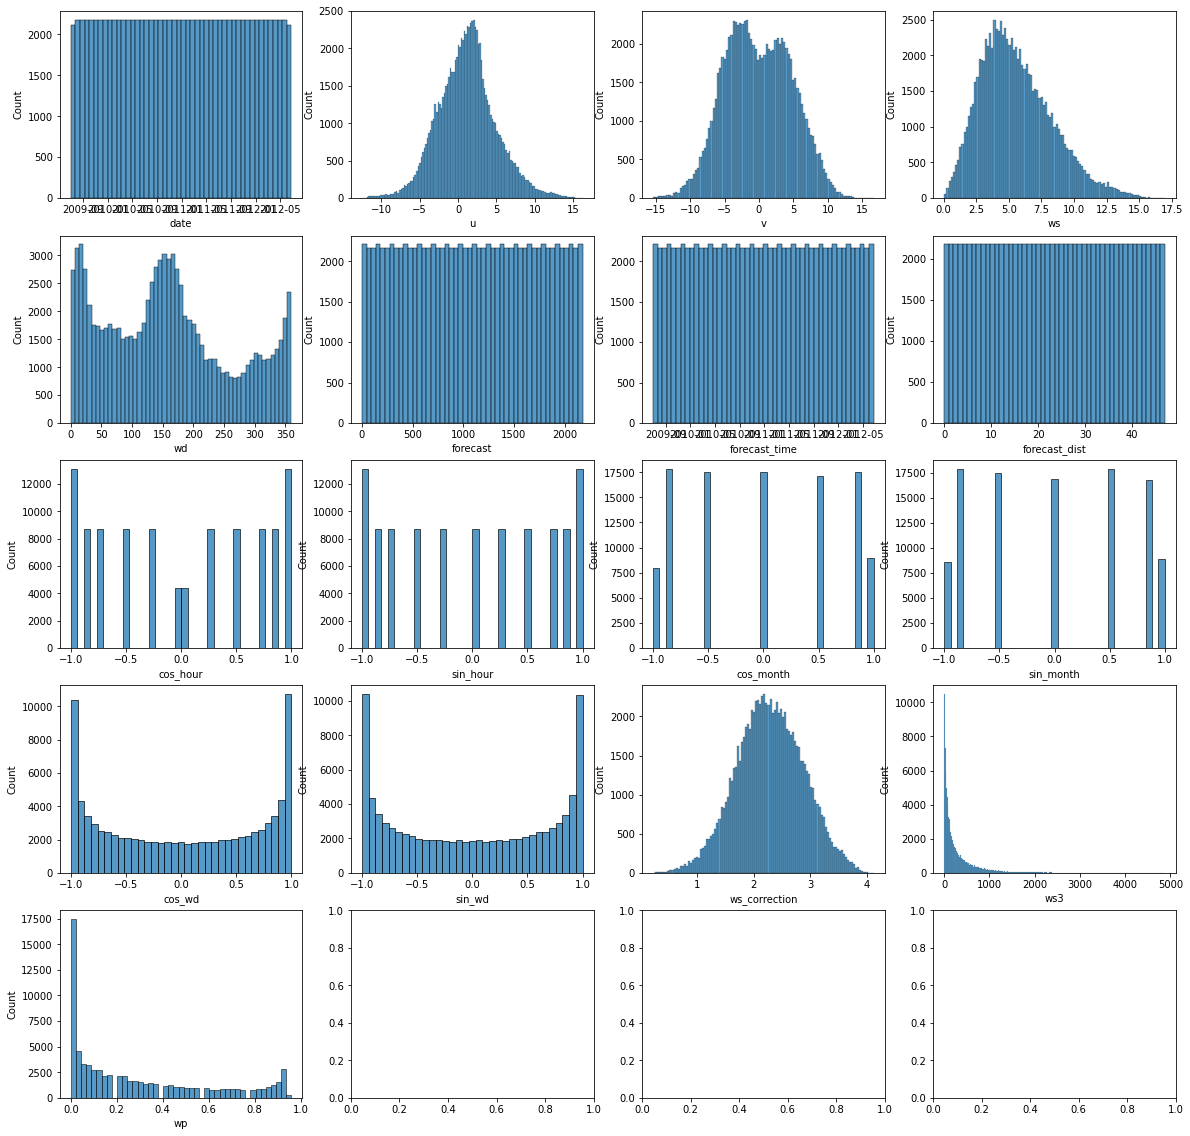

In [63]:
n_rows=5
n_cols=4

a4_dims = (20, 20)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=a4_dims)

for i, column in enumerate(wp_1_forecast.columns):
    sns.histplot(wp_1_forecast[column],ax=axes[i//n_cols,i%n_cols])

In [69]:
wp_1_forecast['ws'].skew()

0.637267201708731

In [70]:
wp_1_forecast['ws_correction'].skew()

-0.03264580351021155

In [150]:
# wp_1_test_data = wp_1_forecast[(wp_1_forecast.date >= start_date)].sort_values(by='date').head(4*48+4*36)
# wp_1_test_data.groupby([wp_1_test_data["date"].dt.year, wp_1_test_data["date"].dt.month, wp_1_test_data["date"].dt.day,  wp_1_test_data["date"].dt.hour]).count().plot(kind="bar", figsize=(40,5))

# A discuter

**To discuss**: Est ce que forecast de la date du test peut être conservée si elle a été émise avant la date test ? (Selon moi oui, mais ce sera dommage d'être disqualifiés pour ça)

***Update 2***:
- Je retire l'idée des 48h à envoyer au modèle, c'est une très très mauvaise idée! Par contre j'ai bien rajouté une colonne forecast_dist qui donne la distance entre l'heure du forecast et la date de la météo forecast.
- Pour les heures de maintenance, le mieux c'est de les retirer. Au départ j'ai pensé à de l'imputation avec la médian, mais on parle de notre target. Ca indurait trop de biais, et ça nous fait perdre que peu de donnée de juste la retirer. On perd 6% de notre donnée entre les retirant...
- Pour le rolling window, je le fais directement sur le jeu de donnée entier. Au final je m'embêtais à séparer test and train en pensant qu'il y avait les 3 forecasts après les 48h à prédire qui étaient manquants. En fait ils sont dans le jeu, juste en NaN au niveau de u,v,... et wp. Donc ça maintient la continuité temporelle ! 
- ws est un peu biaisé (queue plus longue vers la droite). La racine carré corrige bien ce problème, à voir si on garde la version corrigée! ws3 par contre est très biasé (voir distribution), donc peut être pas très pertinent...

Dès que l'on sera OK sur le preprocessing, il faudra se créer une classe Model, avec tout le preprocessing. Ensuite, il faudra enregistrer les jeux de données, et faire note cross validation sur plusieurs modèles. Je pense qu'on peut prévoir un modèle par ferme. 

In [ ]:
# X = training_data['ws'].values.reshape(-1, 1)
# y = training_data['wp1'].values.reshape(-1, 1)


# poly_reg = PolynomialFeatures(degree=3)
# X_poly = poly_reg.fit_transform(X)
# pol_reg = LinearRegression()
# pol_reg.fit(X_poly, y)

# def viz_polymonial(X, y, pol_reg):
#     plt.scatter(X, y, color='red')
#     plt.plot(X, pol_reg.predict(poly_reg.fit_transform(X)), color='blue')
#     plt.title('Linear Regression')
#     plt.xlabel('Wind speed')
#     plt.ylabel('Wind power')
#     plt.show()
#     return

# # training_data['theoretical_power'] = pol_reg.predict(poly_reg.fit_transform(X))
# viz_polymonial(X, y, pol_reg)